In [373]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import utils
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from typing import Iterator
import random
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
seed = 42 # The ultimate answer

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
from datasets import load_dataset, iterable_dataset, Dataset

dataset = load_dataset("nielsr/CelebA-faces", split='train').train_test_split(0.05, seed=seed)
#annotated_ds = load_dataset("flwrlabs/celeba", streaming=True) # For searching semantic vectors

In [294]:
img_height = 160
img_width = 144
img_channels = 1

calc_mean = 0.4377
calc_std = 0.2722

latent_dim = 512

batch_size = 128

In [295]:
class FacesIterDataset(utils.data.IterableDataset):
    def __init__(self, 
                 iterable: iterable_dataset.IterableDataset,
                 transforms: A.Compose
                ):
        self.iterable = iterable
        self.transforms = transforms

    def __iter__(self) -> Iterator[torch.Tensor]:
        for item in self.iterable:
            image = np.array(item['image'])
            image = self.transforms(image=image)['image']

            yield image

class FacesDataset(utils.data.Dataset):
    def __init__(self,
                 dataset: Dataset,
                 transforms: A.Compose
                ):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.dataset)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        image = np.array(self.dataset[idx]['image'])
        image = self.transforms(image=image)['image']

        return image

In [296]:
transforms_list = [
    A.CenterCrop(img_height, img_width, p=1),
    A.ToGray(1, p=1),
    A.Normalize(mean=calc_mean, std=calc_std),
    ToTensorV2()
]

train_transforms = A.Compose([A.HorizontalFlip(p=0.5)] + transforms_list)
transforms = A.Compose(transforms_list)

train_dataloader = utils.data.DataLoader(FacesDataset(dataset['train'], train_transforms),
                              batch_size=batch_size,
                              shuffle=True)

val_dataloader = utils.data.DataLoader(FacesDataset(dataset['test'], transforms),
                              batch_size=batch_size,
                              shuffle=False)

In [8]:
def denormalize(img: torch.Tensor, mean: float = calc_mean, std: float = calc_std) -> np.ndarray:
    return np.clip((img.cpu().detach().numpy() * std + mean)*255, 0, 255).astype(np.uint8)

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int | tuple[int],
                 stride: int | tuple[int],
                 padding: int | tuple[int]
                ):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.elu = nn.ELU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv(x)
        out = self.bn(out)
        out = self.elu(out)

        return out
    

class ConvTpBlock(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 out_channels: int,
                 kernel_size: tuple[int],
                 stride: int | tuple[int],
                 padding: int | tuple[int],
                 output_padding: int | tuple[int]
                ):
        super().__init__()

        self.convt =  nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.elu = nn.ELU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.convt(x)
        out = self.bn(out)
        out = self.elu(out)

        return out

In [10]:
from math import ceil, prod

class Encoder(nn.Module):
    def __init__(self, 
                 img_size: tuple[int],
                 in_channels: int,
                 latent_dim: int,
                 hidden_layers: tuple[int]
                ):
        super().__init__()

        self.encoder = nn.ModuleList()
        
        for layer in hidden_layers:
            self.encoder.append(nn.ModuleDict({
                'conv1': ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
                'conv2': ConvBlock(in_channels, layer, kernel_size=3, stride=2, padding=1)
            }))
            in_channels = layer
        
        self.origin_shape = hidden_layers[-1], ceil(img_size[0] / 2**len(hidden_layers)), ceil(img_size[1] / 2**len(hidden_layers))

        enc_dim = self.origin_shape[0] * self.origin_shape[1] * self.origin_shape[2]
        
        self.fc_mu = nn.Linear(enc_dim, latent_dim)
        self.fc_logvar = nn.Linear(enc_dim, latent_dim)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for block in self.encoder:
            out = block['conv1'](x)
            x = block['conv2'](out + x)
        
        out = torch.flatten(x, start_dim=1)
        
        mu = self.fc_mu(out)
        logvar = self.fc_logvar(out)

        return mu, logvar

In [11]:
class Decoder(nn.Module):
    def __init__(self,
                 out_channels: int,
                 latent_dim: int,
                 origin_shape: tuple[int],
                 hidden_layers: tuple[int],
                 out_pad: tuple[int] = (1, 1)
                ):
        super().__init__()

        self.fc = nn.Linear(latent_dim, prod(origin_shape))

        self.reshape = lambda z: z.view(-1, *origin_shape)

        self.decoder = nn.ModuleList()

        for i, (curr, next) in enumerate(zip(hidden_layers, hidden_layers[1:] + (hidden_layers[-1],))):
            self.decoder.append(nn.ModuleDict({
                'conv': ConvBlock(curr, curr, kernel_size=3, stride=1, padding=1),
                'convt': ConvTpBlock(curr, next, kernel_size=3, stride=2, padding=1, output_padding=(out_pad if not i else 1))
            }))
        
        self.head = nn.Conv2d(hidden_layers[-1], out_channels, kernel_size=3, padding=1)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = self.fc(z)
        z = self.reshape(z)

        for block in self.decoder:
            out = block['conv'](z)
            z = block['convt'](out + z)

        return self.head(z)

In [12]:
class VAE(nn.Module):
    def __init__(self, 
                 img_size: tuple[int],
                 in_channels: int,
                 latent_dim: int = 512,
                 hidden_layers: tuple[int] = (32, 64, 128, 256, 512)
                ):
        super().__init__()
        
        out_pad = (1, 1)

        if img_size[0] % len(hidden_layers) != 0:
            out_pad = (0, 1)
        elif img_size[1] % len(hidden_layers) != 0:
            out_pad = (1, 0)

        self.latent_dim = latent_dim
        self.encoder = Encoder(img_size, in_channels, latent_dim, hidden_layers)
        self.decoder = Decoder(in_channels, latent_dim, self.encoder.origin_shape, hidden_layers[::-1], out_pad)
    
    def forward(self, x: torch.Tensor, stochastic: bool = True) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar) if stochastic else mu
        
        return self.decoder(z), mu, logvar
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return eps * std + mu
    
    def loss(self,
             reconstr: torch.Tensor,
             target: torch.Tensor,
             mu: torch.Tensor, 
             logvar: torch.Tensor
            ) -> tuple[torch.Tensor, torch.Tensor]:
        
        reconstruction_loss = F.mse_loss(reconstr, target)
        regularization_term = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1)

        return reconstruction_loss, regularization_term.mean()

    def sample(self, num: int, device: torch.device) -> torch.Tensor:
        z = torch.randn(num, self.latent_dim, device=device)

        return self.decoder(z)

In [13]:
vae = VAE((img_height, img_width), img_channels, latent_dim)
vae.load_state_dict(torch.load('params_15_epochs.pt', weights_only=True, map_location=device))

<All keys matched successfully>

In [14]:
sum([p.numel() for p in vae.parameters() if p.requires_grad])

26749836

In [12]:
epoch = 50
lr = 3e-4
grad_clip = 1
optimizer = optim.AdamW(vae.parameters(), lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96) # TODO: change to advanced scheduler

rec_losses = []
kl_losses = []
elbo_losses = []

min_elbo = float('inf')

In [13]:
@torch.inference_mode
def visualize_trio(input: torch.Tensor, reconstruction: torch.Tensor, vae: VAE) -> None:
    vae.eval()
    denorm_sample = denormalize(vae.sample(1, device).squeeze((0, 1)))
    denorm_reconst = denormalize(reconstruction)
    denorm_input = denormalize(input)
    concat = np.hstack([denorm_input, denorm_reconst, denorm_sample])
    display(Image.fromarray(concat))
    vae.train()

def visualize_duo(input: torch.Tensor, reconstruction: torch.Tensor) -> None:
    denorm_reconst = denormalize(reconstruction)
    denorm_input = denormalize(input)
    concat = np.hstack([denorm_input, denorm_reconst])
    display(Image.fromarray(concat))

In [ ]:
@torch.inference_mode
def evaluate(vae: VAE, 
             beta: float,
             dataloader: utils.data.DataLoader
            ) -> tuple[float, float]:
    vae.eval()

    running_rec_loss = 0
    running_kl_loss = 0
    total_samples = 0

    for inputs in (pbar := tqdm(dataloader, desc=f'Validation')):
    
        inputs = inputs.to(device)

        reconstructions, mu, logvar = vae(inputs, stochastic=False)

        reconstruction_loss, kl_loss = vae.loss(reconstructions, inputs, mu, logvar)

        running_rec_loss += reconstruction_loss.item() * inputs.size(0)
        running_kl_loss += kl_loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        avg_rec_loss = running_rec_loss / total_samples
        avg_kl_loss = running_kl_loss / total_samples
        avg_elbo_loss = avg_rec_loss + beta * avg_kl_loss

        pbar.set_description(f'Validation | Rec loss: {avg_rec_loss:.05f} | KL loss: {avg_kl_loss:.05f} | Elbo loss: {avg_elbo_loss:.05f}')

    visualize_duo(inputs[0].squeeze(0), reconstructions[0].squeeze(0))

    vae.train()

    return avg_rec_loss, avg_kl_loss

In [ ]:
vae.train()
vae.to(device)

delta = 5e-6
beta = 1e-5

for e in range(epoch):
    #beta = min(0.01, 10 ** (e - 5))

    running_rec_loss = 0
    running_kl_loss = 0
    total_samples = 0

    for i, inputs in (pbar := tqdm(enumerate(train_dataloader), desc=f'Epoch: {e+1}')):
    
        inputs = inputs.to(device)

        reconstructions, mu, logvar = vae(inputs)

        reconstruction_loss, kl_loss = vae.loss(reconstructions, inputs, mu, logvar)
        elbo_loss = reconstruction_loss + beta * kl_loss

        running_rec_loss += reconstruction_loss.item() * inputs.size(0)
        running_kl_loss += kl_loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        optimizer.zero_grad()
        elbo_loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), grad_clip)
        optimizer.step()

        avg_rec_loss = running_rec_loss / total_samples
        avg_kl_loss = running_kl_loss / total_samples
        avg_elbo_loss = avg_rec_loss + avg_kl_loss * 1e-4

        pbar.set_description(f'Epoch: {e+1} | Rec loss: {avg_rec_loss:.05f} | KL loss: {avg_kl_loss:.05f} | Beta = {beta}')

        if (i % 100 == 0):
            visualize_trio(inputs[0].squeeze(0), reconstructions[0].squeeze(0), vae)

        if (i % 300 == 0 and i != 0):
            beta += delta

            if avg_elbo_loss < min_elbo:
                min_elbo = avg_elbo_loss
                torch.save(vae.state_dict(), 'params.pt')

            running_rec_loss = 0
            running_kl_loss = 0
            total_samples = 0

        rec_losses.append(avg_rec_loss)
        kl_losses.append(avg_kl_loss)
        elbo_losses.append(avg_elbo_loss)
    
    val_rec_loss, val_kl_loss = evaluate(vae, beta, val_dataloader)

    torch.save(vae.state_dict(), 'last_params.pt')

    scheduler.step()

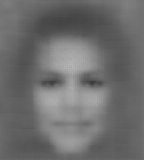

In [404]:
vae.eval()
display(Image.fromarray(denormalize(vae.sample(1, device).squeeze((0, 1)))))

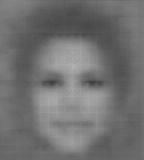

In [111]:
vae.eval()
display(Image.fromarray(denormalize(vae.sample(1, device).squeeze((0, 1)))))

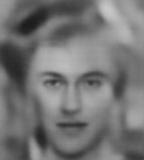

In [89]:
vae.eval()
display(Image.fromarray(denormalize(vae.sample(1, device).squeeze((0, 1)))))

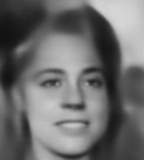

In [244]:
vae.eval()
vae.to(device)
display(Image.fromarray(denormalize(vae.sample(1, device).squeeze((0, 1)))))

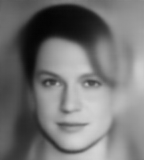

In [ ]:
vae.eval()
display(Image.fromarray(denormalize(vae.sample(1, device).squeeze((0, 1)))))

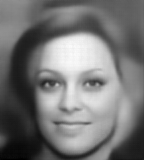

In [234]:
vae.eval()
display(Image.fromarray(denormalize(vae.sample(1, device).squeeze((0, 1)))))

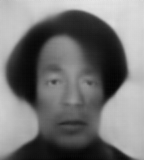

In [195]:
img = transforms(image=np.array(Image.open('test.jpeg').resize((160, 160), Image.Resampling.LANCZOS)))['image']
display(Image.fromarray(denormalize(vae(img.unsqueeze(0).to('cpu'))[0].squeeze((0, 1)))))

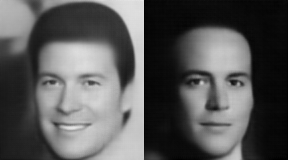

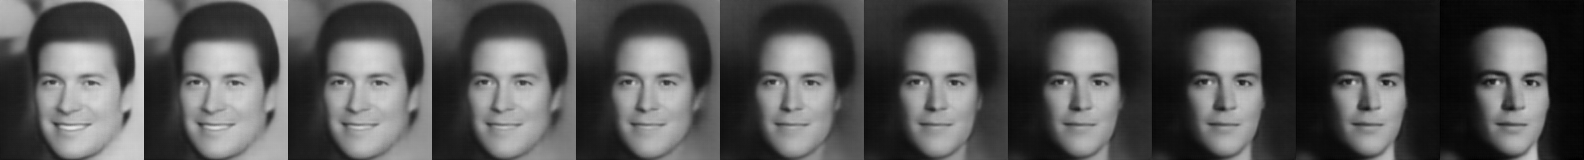

In [372]:
vae.eval()
vae.to(device)

ds = FacesDataset(dataset['test'], transforms)

a = vae.encoder(ds[50].unsqueeze(0))[0]
b = vae.encoder(ds[444].unsqueeze(0))[0]
vec = b - a
display(Image.fromarray(np.hstack([denormalize(vae.decoder(a).squeeze((0, 1))), denormalize(vae.decoder(b).squeeze((0, 1)))])))

display(Image.fromarray(np.hstack([denormalize(vae.decoder(a + vec*i/10).squeeze((0, 1))) for i in range(11)])))

In [370]:
images = [Image.fromarray(denormalize(vae.decoder(a + vec*i/100).squeeze((0, 1)))).resize((img_width * 2, img_height * 2), Image.Resampling.NEAREST) for i in range(100)]

images[0].save('test.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=60, loop=0)